In [52]:
import random
import os
import re
from glob import glob
from tqdm import tqdm
import numpy as np

import pandas as pd
import ast
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from PIL import Image, ImageDraw, _imaging
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras import metrics
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from sklearn.model_selection import train_test_split
import tensorflow as tf
from datetime import datetime
from keras.callbacks import History, ModelCheckpoint
history = History()
from keras.models import model_from_json

In [53]:
def showSampleImgs():
    n_samp = 3
    train_df_sample = train_df.sample(n_samp)
    plt.figure(figsize=(4,4))
    for i in range(n_samp):
        draw = train_df_sample.iloc[i]['drawing']
        label = train_df_sample.iloc[i]['word']
        plt.subplot(n_samp,1,i+1)
        for stroke in draw:
            plt.plot(stroke[0], stroke[1], marker='.', color='black')
            plt.title(label)
            plt.axis('off')
    plt.show()    
    
# Show an image from the dataframe
def showImgFromDf(df, index):
    # Show an image
    plt.imshow(df.iloc[index]['img'],cmap='gray')
    plt.title(df.iloc[index]['word'])
    plt.show()
    
def top_3_accuracy(y_true, y_pred):
    return metrics.top_k_categorical_accuracy(y_true, y_pred, k=3)


def baseline_conv_model(num_filters, num_classes, img_height, img_width):
    model = Sequential()
    model.add(Conv2D(num_filters*1, (5,5), input_shape=(img_height,img_width,1), activation='relu')) 
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(num_filters*2, (5,5), activation='relu')) 
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(num_filters*4, (3,3), activation='relu')) 
#     model.add(MaxPooling2D(pool_size=(2,2)))
#     model.add(Conv2D(num_filters*8, (3,3), activation='relu')) 
    model.add(Dropout(0.2))
    model.add(Flatten())
#     model.add(Dense(2500, activation='relu'))
#     model.add(Dropout(0.2))
    model.add(Dense(2000, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1500, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1000, activation='relu'))
    model.add(Dropout(0.2))
    # model.add(Dense(num_classes, activation='softmax'))
    # model.add(Activation('softmax'))
    model.add(Dense(units=num_classes))
    model.add(Activation(tf.nn.softmax))

    # Compile
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', top_3_accuracy, 'categorical_crossentropy'])
    return model


In [54]:
random.seed(111)

# Generate class mappings
fnames = glob('train_simplified/*.csv')
tempDf = pd.DataFrame(columns=pd.read_csv(fnames[0], nrows=1).columns)

for name in fnames:
    data = pd.read_csv(name, nrows=2)
    tempDf = tempDf.append(data)
    
ys = tempDf['word']
    
# Convert class labels from categorical to numerical
unique_classes_list = ys.unique()
map_class_to_numeric = {k: v for v, k in enumerate(unique_classes_list)}
map_numeric_to_class = {v: k for k, v in map_class_to_numeric.iteritems()}

In [55]:
def draw_it(raw_strokes, output_height, output_width):
    raw_strokes = eval(raw_strokes)
    image = Image.new("P", (255,255)
#                       , color=1
            )
    image_draw = ImageDraw.Draw(image)

    for stroke in raw_strokes:
        for i in range(len(stroke[0])-1):

            image_draw.line([stroke[0][i], 
                             stroke[1][i],
                             stroke[0][i+1], 
                             stroke[1][i+1]],
                            fill=255, width=6)
    # Reduce image size
    image = image.resize((output_height,output_width),Image.ANTIALIAS)
    
    return np.array(image)


class DataGenerator(keras.utils.Sequence):
    def __init__(self, num_samples_to_train, batch_size, trainGeneratorDataOffsetPerClass, img_width, img_height):
        self.batch_size = batch_size
        self.num_samples_to_train = num_samples_to_train
        self.img_width = img_width
        self.img_height = img_height
        self.trainGeneratorDataOffsetPerClass = trainGeneratorDataOffsetPerClass
    
    def __len__(self):
        return np.ceil(self.num_samples_to_train / float(self.batch_size))
    
    def __getitem__(self, idx):
        
        numRowsEachDf = int(self.batch_size / float(numClasses))
        skipRows = (idx * numRowsEachDf) + self.trainGeneratorDataOffsetPerClass
        img_height = self.img_height 
        img_width = self.img_width
        
        X, y = DataGenerator._getNextData(numRowsEachDf, skipRows, img_height, img_width)
        
        return X, y
    
    @staticmethod
    def _getNextData(numRowsEachDf, skipRows, img_height, img_width):
        
        fnames = glob('train_simplified/*.csv')
        numClasses = len(fnames)

        # Get n rows from all the csv files and append them into one dataframe
        train_df = pd.DataFrame(columns=pd.read_csv(fnames[0], nrows=1).columns)
        
        for name in fnames:
            if skipRows == 0:
                data = pd.read_csv(name, nrows=numRowsEachDf)
            else:
                data = pd.read_csv(name, nrows=numRowsEachDf, skiprows=range(1,skipRows)) # 0th row is the header, so not skipping that
            # Append the training data of all the classes
            train_df = train_df.append(data)
            
        train_df = train_df.reset_index().drop('index', axis=1)

        # Shuffle all data points
        train_df = train_df.sample(train_df.shape[0])

        # Get only those which were correctly recognized
        train_df = train_df[train_df['recognized'] == True]

        # Convert drawing to images
        train_df['drawing'] = train_df['drawing'].apply(lambda x: draw_it(x, img_height, img_width))

        # Reshape the array
        train_imgArr = np.vstack(train_df['drawing'].values).flatten().reshape((train_df['drawing'].shape[0], img_height, img_width))
    
        # In Keras, the layers used for two-dimensional convolutions expect pixel values with the dimensions [width][height][pixels] for TF.
        # In the case of RGB, the first dimension pixels would be 3 for the red, green and blue components and it would be like having 3 image inputs for every color image. In this case, the pixel values are gray scale, the pixel dimension is set to 1.
        train_X = train_imgArr.reshape(train_imgArr.shape[0], img_height, img_width, 1).astype('float32')
        
        
         # Initialize the y_train
        y_train = train_df['word']
    
        y_train_numeric = y_train.apply(lambda x: map_class_to_numeric[x])

        # convert class vectors to binary class matrices
        train_y = keras.utils.to_categorical(y_train_numeric, numClasses)
        
        return train_X, train_y
    

In [56]:
img_width = img_height = 64

In [57]:
X_test, y_test = DataGenerator._getNextData(1000, 90000, img_height, img_width)

In [76]:
# pp = []
batch_size = 20000
numTrainExamplesPerClass = 20000
numClasses = 340
num_samples_to_train = (numTrainExamplesPerClass*numClasses)
trainGeneratorDataOffsetPerClass = 20000
dataGenerator = DataGenerator(num_samples_to_train, batch_size, trainGeneratorDataOffsetPerClass, img_width, img_height)

In [ ]:
# model = baseline_conv_model(4, 340, 32, 32)
numStartFilters = 16
# model = baseline_conv_model(numStartFilters, numClasses, img_height, img_width)
model.fit_generator(
        generator=dataGenerator,
        epochs=1,
        verbose=1,
        shuffle=False,
        validation_data=(X_test, y_test)
    
#         ,
#         use_multiprocessing=True,
)
#       steps_per_epoch=(num_training_samples // batch_size),
#       validation_data=my_validation_batch_generator,
#       validation_steps=(num_validation_samples // batch_size),
#       use_multiprocessing=False,
#       workers=16,
#       max_queue_size=32)


Epoch 1/1
161/340 [=============>................] - ETA: 9:06:26 - loss: 1.0211 - acc: 0.7131 - top_3_accuracy: 0.8872 - categorical_crossentropy: 1.0211

In [70]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("CNN Error: %.2f%%" % (100-scores[1]*100))
# model

CNN Error: 26.18%


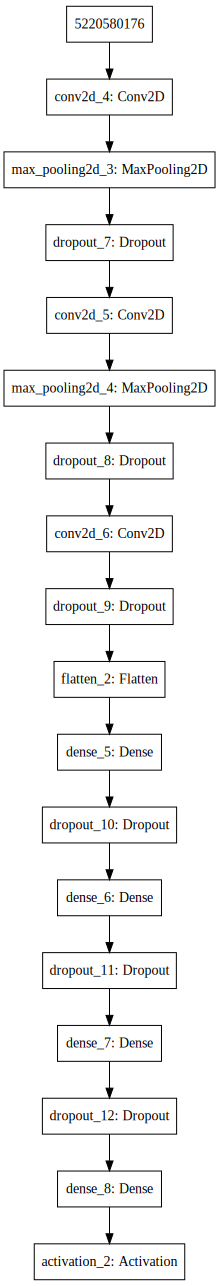

In [51]:
# from keras.utils import plot_model
# plot_model(model)
# from IPython.display import SVG
# from keras.utils.vis_utils import model_to_dot

# SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [132]:
# %%time
# # Transform data for CNN
# X_train, X_test, y_train, y_test, imgArr_test, map_class_to_numeric, map_numeric_to_class = CNN_dataPrep(train_df, img_height, img_width)

In [2]:
# num_filters = 2
# num_classes = 340
# continueTrain = False
# if continueTrain == False:
#     model = baseline_conv_model(num_filters, num_classes, img_height, img_width)

# # checkpoint
# filepath="Saved_Models/weights.best.hdf5"
# checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
# callbacks = [checkpoint]

# print(model.summary())

# hist = model.fit(X_train, 
#           y_train, 
#           validation_data=(X_test, y_test),
#           epochs=2, 
#           batch_size=5, 
#           verbose=2,
#           callbacks = callbacks)

In [75]:
# Save the model
# serialize model to JSON
model_json = model.to_json()
with open(("Saved_Models/model_" + str(datetime.today())[:16].replace(" ", "_").replace(":","-") + ".json"), "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(("Saved_Models/model_" + str(datetime.today())[:16].replace(" ", "_").replace(":","-") + ".h5"))
print("Saved model to disk")

Saved model to disk


In [25]:
# model = ""

In [65]:
# Load the model back
# load json and create model
json_file = open('Saved_Models/model_2018-11-23_09-25.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("Saved_Models/model_2018-11-23_09-25.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', top_3_accuracy, 'categorical_crossentropy'])
# score = loaded_model.evaluate(X, Y, verbose=0)
# print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))
model = loaded_model

Loaded model from disk


In [66]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("CNN Error: %.2f%%" % (100-scores[1]*100))
# model

CNN Error: 26.81%


# Create Test Data Set

In [38]:
def getTestData(img_height, img_width):
        
        numClasses = 340

        test_df = pd.read_csv('test_simplified.csv')            

        # Convert drawing to images
        test_df['drawing'] = test_df['drawing'].apply(lambda x: draw_it(x, img_height, img_width))

        # Reshape the array
        test_imgArr = np.vstack(test_df['drawing'].values).flatten().reshape((test_df['drawing'].shape[0], img_height, img_width))
    
        # In Keras, the layers used for two-dimensional convolutions expect pixel values with the dimensions [width][height][pixels] for TF.
        # In the case of RGB, the first dimension pixels would be 3 for the red, green and blue components and it would be like having 3 image inputs for every color image. In this case, the pixel values are gray scale, the pixel dimension is set to 1.
        test_X = test_imgArr.reshape(test_imgArr.shape[0], img_height, img_width, 1).astype('float32')
                
        return test_df, test_X

In [39]:
test_df, test_X = getTestData(img_width, img_height)

In [71]:
# Make predictions
preds = model.predict(test_X)
outputDf = test_df.copy()[['key_id']]
outputDf['word'] = ''
map_numeric_to_class_space_normal = map_numeric_to_class.copy()
for key in map_numeric_to_class_space_normal:
    map_numeric_to_class_space_normal[key] = (map_numeric_to_class_space_normal[key].replace(" ", "_"))

for i in tqdm(range(preds.shape[0])):
    outputDf['word'].at[i] = ' '.join(([map_numeric_to_class_space_normal[predClass] for predClass in [tup[1] for tup in sorted(zip(preds[i], range(340)), reverse=True)[:3]]]))

# Create csv
outputDf.to_csv('initial_pred.csv', index=False)

100%|██████████| 112199/112199 [00:21<00:00, 5342.23it/s]
